# Question 1: Regression Analysis (without GeoSpatial Data)
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

This notebook explores the same question and target variable as the "Q1_Regression" notebook, but without geospatial data. 

**Question 1:** Can we predict real estate purchase price based on climate indicators?
*Target Variable:* Purchase Price ($thou)
*Task:* Run a regression with linear, polynomial features.

## Importing the Necessary Libraries

In [2]:
# common libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# linear regression libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

ImportError: DLL load failed while importing _path: The specified module could not be found.

## Initial Exploration
We will read in the dataset and see if we need do any cleaning before linear regression model.

In [1]:
#read in the dataset
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

NameError: name 'pd' is not defined

In [2]:
#our regression will not need the date and str-type columns; we also need to change the arbitrary "value" column to "avg. temp."
regression = data[data.columns.difference(['Date', 'State', 'StateAbbrv', 'RegionName'])]
regression = regression.rename(columns={'Value': 'Average Temperature'})
regression.head()

NameError: name 'data' is not defined

## Look for multicollinearity

> findings, findings

<Axes: >

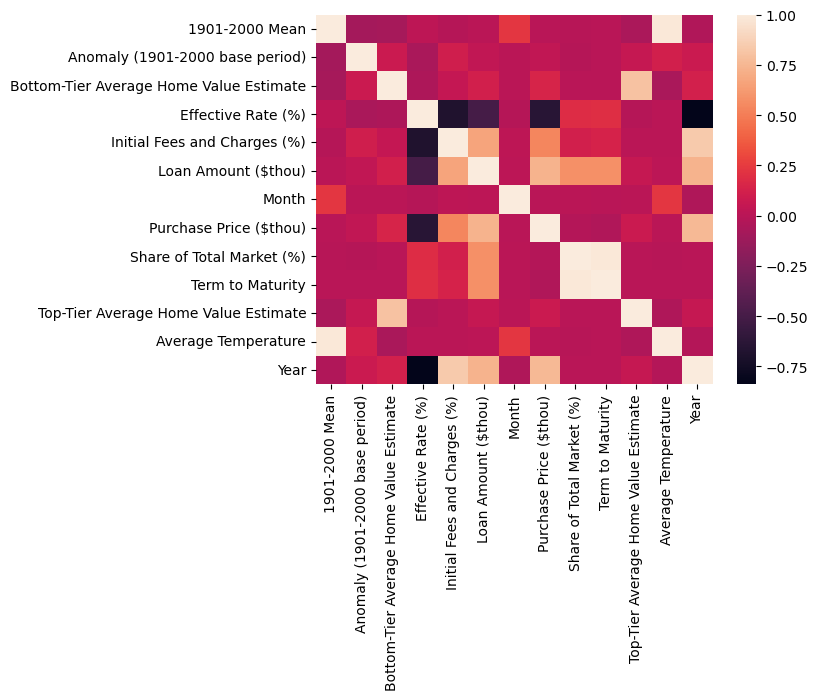

In [4]:
sns.heatmap(data=regression.corr())

## Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [5]:
regression.sort_values(by=['Year', 'Month'])

X_train = regression[regression['Year']!=2019][regression.columns.difference(['Purchase Price ($thou)'])]
X_test = regression[regression['Year']==2019][regression.columns.difference(['Purchase Price ($thou)'])]
y_train = regression[regression['Year']!=2019]['Purchase Price ($thou)']
y_test = regression[regression['Year']==2019]['Purchase Price ($thou)']


In [6]:
X_test.head()

,1901-2000 Mean,Anomaly (1901-2000 base period),Average Temperature,Bottom-Tier Average Home Value Estimate,Effective Rate (%),Initial Fees and Charges (%),Loan Amount ($thou),Month,Share of Total Market (%),Term to Maturity,Top-Tier Average Home Value Estimate,Year
582366,47.8,2.9,50.7,447669.112417,4.43,1.43,198.7,1,6.0,15,1.123773e+06,2019
582367,47.8,2.9,50.7,447669.112417,4.90,1.18,250.7,1,75.1,30,1.123773e+06,2019
582368,22.5,-0.6,21.9,128767.706942,4.43,1.43,198.7,1,6.0,15,4.188487e+05,2019
582369,22.5,-0.6,21.9,128767.706942,4.90,1.18,250.7,1,75.1,30,4.188487e+05,2019
582370,51.8,1.5,53.3,131505.853757,4.43,1.43,198.7,1,6.0,15,3.401442e+05,2019


## Train a Linear Regression Model

In [7]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_test = model_lr.predict(X_test)
y_pred_train = model_lr.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.881
mean_squared_error_train: 155.812
r_squared_test: 0.524
mean_squared_error_test: 47.131


In [19]:
coefficients_lr = pd.DataFrame(data = list(zip(X_train.columns, l_model.coef_)), columns = ['Labels', 'Coefficients'])

coefficients_lr


,Labels,Coefficients
0,1901-2000 Mean,2.480325e+00
1,Anomaly (1901-2000 base period),2.683363e+00
2,Average Temperature,-2.491575e+00
3,Bottom-Tier Average Home Value Estimate,4.822041e-06
4,Effective Rate (%),3.196224e-01
5,Initial Fees and Charges (%),-2.014079e+01
6,Loan Amount ($thou),1.489022e+00
7,Month,-1.740481e-01
8,Share of Total Market (%),-6.092113e-03
9,Term to Maturity,-4.287218e+00


## Polynomial Features
First, I am resetting the test and train datasets back to have the most informatio possible.

In [22]:
for x in range(1,5):
    X_poly = PolynomialFeatures(degree=x)
    X_polynomial_train = X_poly.fit_transform(X_train)
    X_polynomial_test = X_poly.fit_transform(X_test)
    model_poly = LinearRegression()
    model_poly.fit(X_polynomial_train, y_train)

    y_pred_poly_test = model_poly.predict(X_polynomial_test)
    y_pred_poly_train = model_poly.predict(X_polynomial_train)
    r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
    r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

    mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
    mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

    # Printing results for training
    print('----------------------------')
    print("Degree: ", x)
    print('r_squared_train:', r_squared_train_poly)
    print('mean_squared_error_train:', mean_squared_error_train_poly)

    # Printing results for testing
    print('r_squared_test:',r_squared_test_poly)
    print('mean_squared_error_test:',mean_squared_error_test_poly)
    print('----------------------------')
    print("")

----------------------------
Degree:  1
r_squared_train: 0.880653656108282
mean_squared_error_train: 155.81161552031227
r_squared_test: 0.5235051035119602
mean_squared_error_test: 47.13138143853335
----------------------------

----------------------------
Degree:  2
r_squared_train: 0.8606084234782727
mean_squared_error_train: 181.98150039249526
r_squared_test: -1.7449097358783572
mean_squared_error_test: 271.5063450407258
----------------------------

----------------------------
Degree:  3
r_squared_train: 0.9300460579579755
mean_squared_error_train: 91.3277806940721
r_squared_test: 0.7467113279234594
mean_squared_error_test: 25.053458296585703
----------------------------

----------------------------
Degree:  4
r_squared_train: 0.7961870266821898
mean_squared_error_train: 266.0863131715092
r_squared_test: -4.756484942663214
mean_squared_error_test: 569.3892832378818
----------------------------



## Closing Thoughts

The data so far indicates that we may need to change either our questions or our entire dataset. Our hypothesis that temperature change can be used to predict purchase price is "No, that in fact is worse than random."